In [1]:
%load_ext autoreload
%matplotlib inline

In [2]:
%autoreload 2

import sys,os,glob
import numpy as np
import matplotlib
# matplotlib.use("PDF")
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cmx
# from mpl_toolkits.basemap import Basemap
import xarray as xr
from scipy.optimize import curve_fit
# import dask
# from multiprocessing.pool import ThreadPool
# dask.config.set(pool=ThreadPool(8))

## Add own library to path
workdir = os.getcwd()
repodir = workdir
while os.path.basename(repodir) != 'aggregation-and-extreme-rain':
    repodir = os.path.dirname(repodir)
print('repo:',repodir)
thismodule = sys.modules[__name__]
moduledir = os.path.join(repodir,'functions')
sys.path.insert(0,moduledir)
print("Own modules available:", [os.path.splitext(os.path.basename(x))[0]
                                 for x in glob.glob(os.path.join(moduledir,'*.py'))])

## Load own libraries
from thermoConstants import *
from thermoFunctions import *
from statisticalDistributions import *
from slicingAndSubsetting import *
from scalingApproximations import *
from plot1DInvLog import *
from dataFormat import *
from importingData import *
from savingResults import *
from plot2D import *

## Graphical parameters
plt.style.use(os.path.join(matplotlib.get_configdir(),'stylelib/presentation.mplstyle'))

repo: /global/cscratch1/sd/bfildier/dataAnalysis/aggregation-and-extreme-rain
Own modules available: ['thermoConstants', 'setEnv', 'thermoFunctions', 'importingData', 'statisticalDistributions', 'plot1DInvLog', 'dataFormat', 'savingResults', 'thermoConstantsForMoistAdiabat', 'scalingApproximations', 'slicingAndSubsetting', 'thermoFunctionsForMoistAdiabat', 'plot2D']


In [3]:
archivedir = getArchivedir(machine='coriknl')
resultdir = os.path.join(os.path.dirname(moduledir),'results')
figuredir = os.path.join(os.path.dirname(moduledir),'figures')

In [4]:
fromsimname=True

if fromsimname: # Extract simulation attributes from simname
    
    simname = "RCE_MPDATAxTKExCAMxSAM1MOM_4000x4000x15_256x256x64_TKE-SST308-r1"
    print("Simulation name:",simname)
    chunks = simname.split('_')
    case = chunks[0]
    Nxyz = chunks[3]
    Nx,Ny,Nz = np.array(Nxyz.split('x'),dtype=int)
    Nproc = np.max(np.array(Nxyz.split('x'),dtype=int))
    simroot = '_'.join(chunks[:4])
    expname = chunks[4]
    expchunks = expname.split('-')
    SST = int([expchunk[-3:] for expchunk in expchunks if re.match("SST*",expchunk)][0])

else: # Define simname from simulation attributes

    case = 'RCE'
    Nxyz = '256x256x64'
    Nx,Ny,Nz = np.array(Nxyz.split('x'),dtype=int)
    Nproc = np.max(np.array(Nxyz.split('x'),dtype=int))
    simroot = "RCE_MPDATAxTKExCAMxSAM1MOM_4000x4000x15_%s"%Nxyz
    # Experiment name
    SST = 304
#     expname = "TKE-SST%d-r1"%SST
#     expname = "TKE-SST%d-radhomo-r1"%SST
#     expname = "TKE-SST%d-r1-b150-sfcdisagg"%SST
#     expname = "TKE-SST%d-r1-b150-tkzfd4"%SST
    expname = "TKE-SST%d-radhomo-r1-b100-radagg"%SST
    # Simulation full name
    simname = "%s_%s"%(simroot,expname)
    print("Simulation name:",simname)

day_origin = getDayOrigin(expname) #ndays
dt = 15 # s

# Compute last step for 3D files
getMaxStep = False
# getMaxStep = True
if getMaxStep:
    allfiles_3D = glob.glob(os.path.join(archivedir,simname,'OUT_3D/*.nc'))
    allfiles_3D.sort()
    lastfile_3D = allfiles_3D[-1]
    stepmax = int(lastfile_3D.split('_')[-1].split('.')[0])
else:
    stepmax = 576000 # 100 days
#     stepmax = 720000 # 125 days
    
    
daymax = stepmax*dt/24/3600 + day_origin
# First step
ndays = 20
daymin = daymax-ndays
stepmin = int((daymin-day_origin)*24*3600/dt)
print("daymin, daymax =",(daymin,daymax))
print("stepmin, stepmax =",(stepmin,stepmax))

Simulation name: RCE_MPDATAxTKExCAMxSAM1MOM_4000x4000x15_256x256x64_TKE-SST308-r1
daymin, daymax = (80.0, 100.0)
stepmin, stepmax = (460800, 576000)


In [5]:
print("Load data")

# load 2D data
print("..2D")
file_pattern_2D = os.path.join(archivedir,simname,'OUT_2D','%s_%d.2Dcom_*.nc'%(simname,Nproc))
var2drop = ['PBLH', 'SHF', 'LHF', 'LWNS', 'LWNSC', 'LWNT', 'LWNTC',\
            'SOLIN', 'SWNS', 'SWNSC', 'SWNT', 'SWNTC', 'CWP', 'IWP', 'CLD', 'USFC', 'U200',\
            'VSFC', 'V200', 'W730', 'PSFC', 'SWVP', 'U850', 'V850', 'ZC', 'TB', 'ZE']
ds_2D = xr.open_mfdataset(file_pattern_2D,decode_cf=False,data_vars=['Prec'],drop_variables=var2drop)

# Check times available in 2D file and update time range if necessary
if daymax > ds_2D['time'][-1]:
    # update daymax, stepmax
    daymax = float(floor(ds_2D['time'][-1]))
    stepmax = int(daymax*24*3600/dt)
    # update daymin, daymin
    daymin = daymax-ndays
    stepmin = int((daymin-day_origin)*24*3600/dt)
    # print new range
    print("-- Updating time range:")
    print("daymin, daymax =",(daymin,daymax))
    print("stepmin, stepmax =",(stepmin,stepmax))

# load 3D data
print("..3D")
steprange = (stepmin,stepmax)
files_in_steprange = get3DFilesBetweenSteps(archivedir,simname,steprange)
ds_3D = xr.open_mfdataset(files_in_steprange,decode_cf=False)

Load data
..2D
-- Updating time range:
daymin, daymax = (63.0, 83.0)
stepmin, stepmax = (362880, 478080)
..3D


In [6]:
print("define time slice for 2D data")

# Find i2D_max
i2D_max = np.where(ds_2D['time'] == daymax)[0][0]

# Find i2D_min
if daymin < ds_2D['time'][0]:
    i2D_min = 0
else:
    i2D_min = np.where(np.abs(ds_2D['time'].data-(daymin+1/24)) < 1e-3)[0][0]
# i2D_min = np.where(ds_2D['time'] == daymin)[0][0]

s_t2D = slice(i2D_min,i2D_max+1)
print(daymin, daymax)
print('index range:',(i2D_min,i2D_max))

define time slice for 2D data
63.0 83.0
index range: (1512, 1991)


In [9]:
figdir = os.path.join(figuredir,simroot,expname)
if not os.path.exists(figdir): os.makedirs(figdir)
    
resdir = os.path.join(resultdir,simroot,expname)
if not os.path.exists(resdir): os.makedirs(resdir)

In [10]:
figsubdir_contributions = os.path.join(figdir,'dynamic_thermo_contributions')
if not os.path.exists(figsubdir_contributions): os.makedirs(figsubdir_contributions)
    
ressubdir_contributions = os.path.join(resdir,'dynamic_thermo_contributions')
if not os.path.exists(ressubdir_contributions): os.makedirs(ressubdir_contributions)

# Reference stats

In [11]:
loadresultsubdir = os.path.join(resdir,'xy_stats_over_time')

In [12]:
print("Load reference precipitation statistics")
i_w24 = 5 # storage index for statistics computed over 24 time slices for rainfall pdfs
perc_ILQ_pr = pickle.load(open(os.path.join(loadresultsubdir,'mean_percentiles_consec_sample_ILQ_pr.pickle'),'rb'))[i_w24]
bins_ILQ_pr = pickle.load(open(os.path.join(loadresultsubdir,'mean_bins_consec_sample_ILQ_pr.pickle'),'rb'))[i_w24]
ranks_ILQ_pr = pickle.load(open(os.path.join(loadresultsubdir,'ranks_ILQ_pr.pickle'),'rb'))
ranks = list(ranks_ILQ_pr.values())[0]

Load reference precipitation statistics


In [13]:
print("Define reference ranks and location of extremes")

Q_IL = ranks
Qmax = 99.99
iQmax = indexOfRank(Qmax,Q_IL)
ranks_ref = Q_IL[:iQmax]
Qmin = 0
iQmin = indexOfRank(Qmin,Q_IL)
targetranks = Q_IL[iQmin:iQmax]

Qref = 99.9
iQref = indexOfRank(Qref,Q_IL)

sQ999_9999 = slice(iQref,iQmax)

Define reference ranks and location of extremes


In [14]:
print("Find location of extremes shifted by an hour")

rank_locations_m1h= {}
rank_locations_m2h= {}
rank_locations_m4h= {}
for rank in ranks_ref:
    rank_id  = "%2.4f"%rank
    print(rank_id,end=' ')
    rank_locations_m1h[rank_id] = np.array(getRankLocations(rank,pr.data,ranks,bins_ILQ_pr,rank_locations_m1h,time_shift=-1))
#     rank_locations_m2h[rank_id] = np.array(getRankLocations(rank,pr.data,ranks,bins_ILQ_pr,rank_locations_m2h,time_shift=-2))
#     rank_locations_m4h[rank_id] = np.array(getRankLocations(rank,pr.data,ranks,bins_ILQ_pr,rank_locations_m4h,time_shift=-4))
print()

Find location of extremes shifted by an hour
20.5672 36.9043 49.8813 60.1893 68.3772 74.8811 80.0474 84.1511 87.4107 90.0000 92.0567 93.6904 94.9881 96.0189 96.8377 97.4881 98.0047 98.4151 98.7411 99.0000 99.2057 99.3690 99.4988 99.6019 99.6838 99.7488 99.8005 99.8415 99.8741 99.9000 99.9206 99.9369 99.9499 99.9602 99.9684 99.9749 99.9800 99.9842 99.9874 


# Implement scaling

## single-level

In [15]:
doSingleLevel = False

In [16]:
# w_prQ_m1h = meanXProfileAtAllYRanks(targetranks,ds_3D.W.data.compute(),pr.data.compute(),ranks,bins,rank_locations_m1h)
# temp_prQ_m1h = meanXProfileAtAllYRanks(targetranks,ds_3D.TABS.data.compute(),pr.data.compute(),ranks,bins,rank_locations_m1h)

In [17]:
if doSingleLevel:

    print('Compute maximum w in the vertical, T in the boundary layer, and use them for a single-level scaling')
    wmax = np.array(np.max(ds_3D.W.data,axis=1))
    i925 = np.argmin(np.abs(np.mean(ds_3D.p,axis=0)-925)).compute()
    temp925 = np.array(ds_3D.TABS[:,i925,...])
    qvstar925 = saturationSpecificHumidity(temp925,92500)
    # qv925 = np.array(ds_3D.QV[:,i925,...])

In [18]:
if doSingleLevel:

    print("percentile-conditioned predictors")
    wmax_prQ = meanXAtAllYRanks(targetranks,wmax,pr,ranks_ref,bins=bins_ILQ_pr,rank_locations=rank_locations_m1h)
    qvstar925_prQ = meanXAtAllYRanks(targetranks,qvstar925,pr,ranks_ref,bins=bins_ILQ_pr,rank_locations=rank_locations_m1h)
    # qv925_prQ = meanXAtAllYRanks(targetranks,qv925,pr,ranks_ref,bins=bins_ILQ_pr,rank_locations=rank_locations_m1h)

In [19]:
if doSingleLevel:
    epsSL = perc_ILQ_pr[iQref]/86400/(wmax_prQ[iQref]*qvstar925_prQ[iQref])
    # epsSL_qv = perc_ILQ_pr[iQref]/86400/(wmax_prQ[iQref]*qv925_prQ[iQref])

In [20]:
if doSingleLevel:
    print(perc_ILQ_pr[iQref],(epsSL*wmax_prQ*qvstar925_prQ)[iQref]*86400)

In [21]:
if doSingleLevel:

    fig,ax = plt.subplots(figsize=(5,5))
    subplotRanksILog(ax,ranks_ref,perc_ILQ_pr[:iQmax],col='k',labels='P')
    subplotRanksILog(ax,ranks_ref,epsSL*wmax_prQ*qvstar925_prQ*86400,col='k',ltype=':',
                     labels='scaling',transformX=True)
    ax.set_xlabel("Percentile rank (%)")
    ax.set_ylabel("Rainfall intensity (%)")
    ax.legend(fontsize=12)
    plt.savefig(os.path.join(figsubdir_contributions,'pdf_rain_and_SL_scaling_wmax.pdf'),bbox_layout='tight')
    plt.show()

In [22]:
if doSingleLevel:

    print("save")
    save2object(wmax_prQ,os.path.join(figsubdir_contributions,"wmax_SLscaling_prQ.pickle"))
    save2object(qvstar925_prQ,os.path.join(figsubdir_contributions,"qvstar925_SLscaling_prQ.pickle"))

## Full scaling

In [23]:
doFullScaling = True

In [24]:
np.array(ds_3D.W).shape

(480, 64, 256, 256)

In [25]:
pr.shape

(480, 256, 256)

In [26]:
if doFullScaling:
    print("percentile-conditioned predictor profiles")
    w = np.array(ds_3D.W)
    w_prQ = meanXProfileAtAllYRanks(targetranks,w,pr,ranks_ref,bins=bins_ILQ_pr,rank_locations=rank_locations_m1h)
    del locals()['w']
    tabs = np.array(ds_3D.TABS)
    tabs_prQ = meanXProfileAtAllYRanks(targetranks,tabs,pr,ranks_ref,bins=bins_ILQ_pr,rank_locations=rank_locations_m1h)
    del locals()['tabs']
    qv = np.array(ds_3D.QV)
    qv_prQ = meanXProfileAtAllYRanks(targetranks,qv,pr,ranks_ref,bins=bins_ILQ_pr,rank_locations=rank_locations_m1h)
#     qv_m2h_prQ = meanXProfileAtAllYRanks(targetranks,qv,pr,ranks_ref,bins=bins_ILQ_pr,rank_locations=rank_locations_m2h)
#     qv_m4h_prQ = meanXProfileAtAllYRanks(targetranks,qv,pr,ranks_ref,bins=bins_ILQ_pr,rank_locations=rank_locations_m4h)
    del locals()['qv']

percentile-conditioned predictor profiles


In [27]:
if doFullScaling:

    prFT_prQ = np.nan*np.zeros(ranks_ref.shape)

    p_profile = np.array(np.mean(ds_3D.p,axis=0))

    for rank in targetranks:

        irank_ref = indexOfRank(rank,ranks_ref)
        irank_target = indexOfRank(rank,targetranks)

        w_prof = w_prQ[irank_target]
        tabs_prof = tabs_prQ[irank_target]

        prFT_prQ[irank_ref] = scalingOGS09_zcoord(w_prof,tabs_prof,p_profile,levdim=0)

In [28]:
if doFullScaling:

    def computePE(perc_ILQ_pr,pr_sc):

        x = pr_sc[sQ999_9999]
        y = perc_ILQ_pr[sQ999_9999]/86400
        f = lambda x,alpha: alpha*x

        return curve_fit(f,x,y,p0=1)

    eps_FT, ecov_FT = computePE(perc_ILQ_pr,prFT_prQ)

    epsFT = eps_FT[0]
    print(epsFT)

0.0551067658721


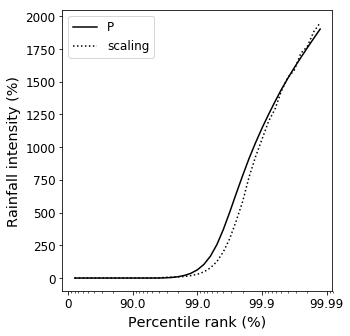

In [29]:
if doFullScaling:
    
    fig,ax = plt.subplots(figsize=(5,5))
    subplotRanksILog(ax,ranks_ref,perc_ILQ_pr[:iQmax],col='k',labels='P')
    subplotRanksILog(ax,ranks_ref,epsFT*prFT_prQ*86400,col='k',ltype=':',labels='scaling',transformX=True)
    ax.set_xlabel("Percentile rank (%)")
    ax.set_ylabel("Rainfall intensity (%)")
    ax.legend(fontsize=12)
    plt.savefig(os.path.join(figsubdir_contributions,'pdf_rain_and_FT_scaling.pdf'),bbox_layout='tight')
    plt.show()

In [30]:
if doFullScaling:
    print("save")
    save2object(w_prQ,os.path.join(ressubdir_contributions,"w_prof_FTscaling_prQ.pickle"))
    save2object(tabs_prQ,os.path.join(ressubdir_contributions,"tabs_prof_FTscaling_prQ.pickle"))
    save2object(qv_prQ,os.path.join(ressubdir_contributions,"qv_prof_FTscaling_prQ.pickle"))
    save2object(p_profile,os.path.join(ressubdir_contributions,"p_prof_FTscaling.pickle"))
    save2object(epsFT,os.path.join(ressubdir_contributions,"alpha_FTscaling.pickle"))

save


## With entrainment, such as Loriaux (2013)

In [31]:
if doFullScaling:

    prFTE_prQ = np.nan*np.zeros(ranks_ref.shape)
    prFTE_qvm2h_prQ = np.nan*np.zeros(ranks_ref.shape)
    
    p_profile = np.array(np.mean(ds_3D.p,axis=0))

    for rank in targetranks:

        irank_ref = indexOfRank(rank,ranks_ref)
        irank_target = indexOfRank(rank,targetranks)

        w_prof = w_prQ[irank_target]
        tabs_prof = tabs_prQ[irank_target]
        qv_prof = qv_prQ[irank_target]
#         qv_m2h_prof = qv_m2h_prQ[irank_target]

        prFTE_prQ[irank_ref] = scalingL13_zcoord(w_prof,tabs_prof,p_profile,qv_prof,levdim=0)
#         prFTE_qvm2h_prQ[irank_ref] = scalingL13_zcoord(w_prof,tabs_prof,p_profile,qv_m2h_prof,levdim=0)
#         prFTE_qvm4h_prQ[irank_ref] = scalingL13_zcoord(w_prof,tabs_prof,p_profile,qv_m4h_prof,levdim=0)

### Tune for entrainment alone

In [32]:
def computeEntrainment(perc_ILQ_pr,prFT_prQ,prFTE_prQ):
    
    x = np.vstack([prFT_prQ[sQ999_9999],prFTE_prQ[sQ999_9999]])
    y = perc_ILQ_pr[sQ999_9999]/86400
    f = lambda x,e: x[0]+e*x[1]
    
    return curve_fit(f,x,y,p0=1e-4)

if doFullScaling:
    e_FTE, ecov_FTE = computeEntrainment(perc_ILQ_pr,prFT_prQ,prFTE_prQ)
#     e_FTE_qvm2h, ecov_FTE_qvm2h = computeEntrainment(perc_ILQ_pr,prFT_prQ,prFTE_qvm2h_prQ)
    print(e_FTE)
#     print(e_FTE_qvm2h)

[ 0.00033626]


In [33]:
# Define scaling with entrainment
if doFullScaling:
    pr_scFTent = (prFT_prQ + e_FTE*prFTE_prQ)*86400
#     pr_scFTent_qvm2h = (prFT_prQ + e_FTE_qvm2h*prFTE_qvm2h_prQ)*86400

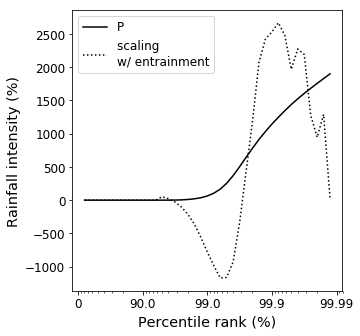

In [34]:
if doFullScaling:
    
    fig,ax = plt.subplots(figsize=(5,5))
    subplotRanksILog(ax,ranks_ref,perc_ILQ_pr[:iQmax],col='k',labels='P')
    subplotRanksILog(ax,ranks_ref,pr_scFTent,col='k',ltype=':',labels='scaling \nw/ entrainment',transformX=True)
    ax.set_xlabel("Percentile rank (%)")
    ax.set_ylabel("Rainfall intensity (%)")
    ax.legend(fontsize=12)
    plt.savefig(os.path.join(figsubdir_contributions,'pdf_rain_and_FTE_scaling.pdf'),bbox_layout='tight')
    plt.show()

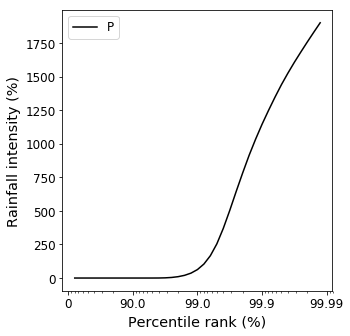

In [35]:
if doFullScaling:
    
    fig,ax = plt.subplots(figsize=(5,5))
    subplotRanksILog(ax,ranks_ref,perc_ILQ_pr[:iQmax],col='k',labels='P',transformX=True)
#     subplotRanksILog(ax,ranks_ref,pr_scFTent_qvm2h,col='k',ltype=':',labels='scaling \nw/ entrainment',transformX=True)
    ax.set_xlabel("Percentile rank (%)")
    ax.set_ylabel("Rainfall intensity (%)")
    ax.legend(fontsize=12)
    plt.savefig(os.path.join(figsubdir_contributions,'pdf_rain_and_FTE_qvm2h_scaling.pdf'),bbox_layout='tight')
    plt.show()

### Tune for entrainment and precipitation efficiency

In [36]:
def computeEntrainmentAndPE(perc_ILQ_pr,prFT_prQ,prFTE_prQ):
    
    x = np.vstack([prFT_prQ[sQ999_9999],prFTE_prQ[sQ999_9999]])
    y = perc_ILQ_pr[sQ999_9999]/86400
    f = lambda x,alpha,e: alpha*(x[0]+e*x[1])

    return curve_fit(f,x,y,p0=(1,1e-4))

if doFullScaling:
    (alpha_FTEE,e_FTEE), ecov_FTEE = computeEntrainmentAndPE(perc_ILQ_pr,prFT_prQ,prFTE_prQ)
#     (alpha_FTEE_qvm2h,e_FTEE_qvm2h), ecov_FTEE_qvm2h = computeEntrainmentAndPE(perc_ILQ_pr,prFT_prQ,prFTE_qvm2h_prQ)

In [37]:
# Define scaling with entrainment and precipitation efficiency
if doFullScaling:
    pr_scFTEE = alpha_FTEE*(prFT_prQ + e_FTEE*prFTE_prQ)*86400
#     pr_scFTEE_qvm2h = alpha_FTEE_qvm2h*(prFT_prQ + e_FTEE_qvm2h*prFTE_qvm2h_prQ)*86400
    print(alpha_FTEE, e_FTEE)
#     print(alpha_FTEE_qvm2h, e_FTEE_qvm2h)

0.0891369284309 0.000136079536852


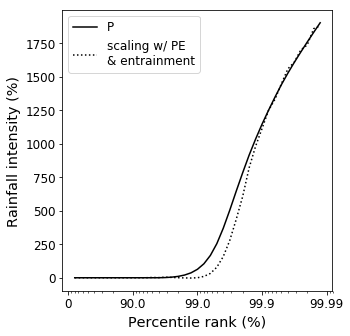

In [38]:
if doFullScaling:
    
    fig,ax = plt.subplots(figsize=(5,5))
    subplotRanksILog(ax,ranks_ref,perc_ILQ_pr[:iQmax],col='k',labels='P')
    subplotRanksILog(ax,ranks_ref,pr_scFTEE,col='k',ltype=':',labels='scaling w/ PE\n& entrainment',transformX=True)
    ax.set_xlabel("Percentile rank (%)")
    ax.set_ylabel("Rainfall intensity (%)")
    ax.legend(fontsize=12)
    plt.savefig(os.path.join(figsubdir_contributions,'pdf_rain_and_FTEalpha_scaling.pdf'),bbox_layout='tight')
    plt.show()

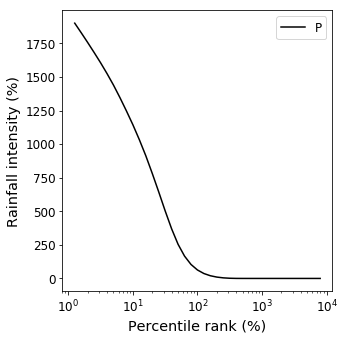

In [39]:
if doFullScaling:
    
    fig,ax = plt.subplots(figsize=(5,5))
    subplotRanksILog(ax,ranks_ref,perc_ILQ_pr[:iQmax],col='k',labels='P')
#     subplotRanksILog(ax,ranks_ref,pr_scFTEE_qvm2h,col='k',ltype=':',labels='scaling w/ PE\n& entrainment',transformX=True)
    ax.set_xlabel("Percentile rank (%)")
    ax.set_ylabel("Rainfall intensity (%)")
    ax.legend(fontsize=12)
    plt.savefig(os.path.join(figsubdir_contributions,'pdf_rain_and_FTEalpha_qvm2h_scaling.pdf'),bbox_layout='tight')
    plt.show()

In [40]:
if doFullScaling:
    save2object(epsFT,os.path.join(ressubdir_contributions,"alpha_FTscaling.pickle"))
    save2object(e_FTE,os.path.join(ressubdir_contributions,"e_FTEscaling.pickle"))
    save2object(e_FTEE,os.path.join(ressubdir_contributions,"e_FTEEscaling.pickle"))
    save2object(alpha_FTEE,os.path.join(ressubdir_contributions,"alpha_FTEEscaling.pickle"))
#     save2object(e_FTEE_qvm2h,os.path.join(ressubdir_contributions,"e_FTEE_qvm2h_scaling.pickle"))
#     save2object(alpha_FTEE_qvm2h,os.path.join(ressubdir_contributions,"alpha_FTEE_qvm2h_scaling.pickle"))
